# LSTM Multiserie e Multivariada

## Dataset

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler

In [29]:
trip = pd.read_csv("./data/ieee/TripA01.csv", sep=";", encoding='unicode_escape')
trip.head()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,AirCon Power [kW],Heater Signal,Heater Voltage [V],Heater Current [A],Ambient Temperature [°C],Coolant Temperature Heatercore [°C],Requested Coolant Temperature [°C],Coolant Temperature Inlet [°C],Heat Exchanger Temperature [°C],Cabin Temperature Sensor [°C]
0,0.0,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.20,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
1,0.1,0.0,574.0,0.0,0.0,0.00,0.0,391.4,-2.21,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
2,0.2,0.0,574.0,0.0,0.0,-0.01,0.0,391.4,-2.26,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
3,0.3,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
4,0.4,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5


In [30]:
trip.columns

Index(['Time [s]', 'Velocity [km/h]', 'Elevation [m]', 'Throttle [%]',
       'Motor Torque [Nm]', 'Longitudinal Acceleration [m/s^2]',
       'Regenerative Braking Signal ', 'Battery Voltage [V]',
       'Battery Current [A]', 'Battery Temperature [°C]',
       'max. Battery Temperature [°C]', 'SoC [%]', 'displayed SoC [%]',
       'min. SoC [%]', 'max. SoC [%)', 'Heating Power CAN [kW]',
       'Heating Power LIN [W]', 'Requested Heating Power [W]',
       'AirCon Power [kW]', 'Heater Signal', 'Heater Voltage [V]',
       'Heater Current [A]', 'Ambient Temperature [°C]',
       'Coolant Temperature Heatercore [°C]',
       'Requested Coolant Temperature [°C]', 'Coolant Temperature Inlet [°C]',
       'Heat Exchanger Temperature [°C]', 'Cabin Temperature Sensor [°C]'],
      dtype='object')

In [31]:
trip.describe()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,AirCon Power [kW],Heater Signal,Heater Voltage [V],Heater Current [A],Ambient Temperature [°C],Coolant Temperature Heatercore [°C],Requested Coolant Temperature [°C],Coolant Temperature Inlet [°C],Heat Exchanger Temperature [°C],Cabin Temperature Sensor [°C]
count,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,10090.000000,...,10090.000000,10090.0,10090.0,10090.0,10090.000000,10090.0,10090.0,10090.0,10090.000000,10090.000000
mean,504.450000,26.502170,566.791625,26.470424,8.106545,0.014246,0.118162,388.483996,-11.953476,21.940141,...,1.610408,1.0,0.0,0.0,30.769972,0.0,0.0,0.0,8.589470,23.907057
std,291.287644,15.497032,5.577563,16.370510,42.123984,0.741669,0.322172,2.158318,22.799614,0.237147,...,0.340490,0.0,0.0,0.0,1.619032,0.0,0.0,0.0,7.124407,1.249755
min,0.000000,0.000000,558.000000,0.000000,-87.050000,-2.290000,0.000000,380.420000,-100.700000,21.000000,...,0.400000,1.0,0.0,0.0,25.500000,0.0,0.0,0.0,5.000000,22.170000
25%,252.225000,15.362500,562.090000,13.550000,-9.157500,-0.330000,0.000000,387.190000,-22.197500,22.000000,...,1.580000,1.0,0.0,0.0,30.500000,0.0,0.0,0.0,5.000000,22.670000
50%,504.450000,29.550000,565.000000,31.100000,4.630000,0.020000,0.000000,388.540000,-8.570000,22.000000,...,1.670000,1.0,0.0,0.0,31.000000,0.0,0.0,0.0,5.000000,24.000000
75%,756.675000,38.720000,574.000000,40.357500,23.540000,0.350000,0.000000,390.000000,-1.990000,22.000000,...,1.760000,1.0,0.0,0.0,32.000000,0.0,0.0,0.0,7.000000,25.010000
max,1008.900000,53.300000,574.000000,55.900000,174.420000,2.790000,1.000000,394.470000,66.220000,22.000000,...,2.520000,1.0,0.0,0.0,33.500000,0.0,0.0,0.0,30.500000,25.840000


In [32]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10090 entries, 0 to 10089
Data columns (total 28 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Time [s]                             10090 non-null  float64
 1   Velocity [km/h]                      10090 non-null  float64
 2   Elevation [m]                        10090 non-null  float64
 3   Throttle [%]                         10090 non-null  float64
 4   Motor Torque [Nm]                    10090 non-null  float64
 5   Longitudinal Acceleration [m/s^2]    10090 non-null  float64
 6   Regenerative Braking Signal          10090 non-null  float64
 7   Battery Voltage [V]                  10090 non-null  float64
 8   Battery Current [A]                  10090 non-null  float64
 9   Battery Temperature [°C]             10090 non-null  float64
 10  max. Battery Temperature [°C]        10090 non-null  float64
 11  SoC [%]                     

In [33]:
trip = trip.sort_values("Time [s]")
trip.head()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,AirCon Power [kW],Heater Signal,Heater Voltage [V],Heater Current [A],Ambient Temperature [°C],Coolant Temperature Heatercore [°C],Requested Coolant Temperature [°C],Coolant Temperature Inlet [°C],Heat Exchanger Temperature [°C],Cabin Temperature Sensor [°C]
0,0.0,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.20,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
1,0.1,0.0,574.0,0.0,0.0,0.00,0.0,391.4,-2.21,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
2,0.2,0.0,574.0,0.0,0.0,-0.01,0.0,391.4,-2.26,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
3,0.3,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5
4,0.4,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,0.4,1,0,0,25.5,0,0,0,30.5,24.5


## Preprocessamento

In [34]:
X = trip.drop(columns=['Time [s]', 'Motor Torque [Nm]']).values
y = trip['Motor Torque [Nm]'].values

In [35]:
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

## Janelamento e Treinamento do Modelo

In [37]:
def LSTM_model(data, labels, window_size=10, train_size=0.8, epochs=10):
    # Janelando os dados
    X_seq, y_seq = [], []
    
    for i in range(window_size, len(data)):
        X_seq.append(data[i-window_size:i, :])
        y_seq.append(labels[i])
        
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    
    # Divisão de treino e teste com 80% para treino e 20% para teste
    train_size = int(len(X_seq) * train_size)
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]


    # Criando e treinando o modelo
    model = Sequential(
        [
            LSTM(32, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
            Dense(32, activation='relu'), 
            Dense(1) 
        ]
    )

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=16)


    # Imprimindo a avaliação
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid()

    loss, mae = model.evaluate(X_test, y_test)
    print(f"MAE: {mae:.8f}, Loss: {loss:.8f}")

    return model

Epoch 1/20


/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1272.9980 - mae: 23.7016 - val_loss: 435.3894 - val_mae: 15.6325
Epoch 2/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 142.4910 - mae: 8.1901 - val_loss: 181.7064 - val_mae: 11.7323
Epoch 3/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 58.5152 - mae: 5.2959 - val_loss: 250.6034 - val_mae: 13.1038
Epoch 4/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 42.5409 - mae: 4.5406 - val_loss: 96.5101 - val_mae: 7.9157
Epoch 5/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 34.0604 - mae: 4.0633 - val_loss: 104.4665 - val_mae: 8.0128
Epoch 6/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 27.6622 - mae: 3.5745 - val_loss: 105.7803 - val_mae: 8.5106
Epoch 7/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 26.0682 - mae: 3.5354 - val_loss: 72.0297 - val_mae: 6.9678
Epoch 8/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 23.1922 - mae: 3.3229 - val_loss: 189.2829 - val_mae: 10.1411
Epoch 9/20
504/504 ━━━━

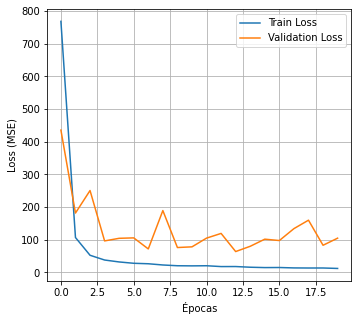

In [38]:
model = LSTM_model(X_scaled, y, window_size=10, train_size=0.8, epochs=20)

## Treinamento e Avaliação do Modelo com N series

### Preparação do Dataset

In [48]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [49]:
directory = "./data/ieee/"
files = os.listdir(directory)
files.sort()

trips = []
for file in files:
    trip = pd.read_csv(directory + file, sep=";", encoding='unicode_escape')
    trip = trip.sort_values(by='Time [s]')
    trip['Trip'] = file.split(".")[0]
    trips.append(trip)

columns = []
for trip in trips:
    if 'Velocity [km/h]]]' in trip.columns:
        trip = trip.rename(columns={'Velocity [km/h]]]': 'Velocity [km/h]'})
        print(trip['Trip'].unique())
    columns.append(trip.columns.tolist())

grupo_colunas_unicos = [list(x) for x in set(tuple(lst) for lst in columns)]
grupo_colunas_unicos

['TripB38']


[['Time [s]',
  'Velocity [km/h]',
  'Elevation [m]',
  'Throttle [%]',
  'Motor Torque [Nm]',
  'Longitudinal Acceleration [m/s^2]',
  'Regenerative Braking Signal ',
  'Battery Voltage [V]',
  'Battery Current [A]',
  'Battery Temperature [°C]',
  'max. Battery Temperature [°C]',
  'SoC [%]',
  'displayed SoC [%]',
  'min. SoC [%]',
  'max. SoC [%)',
  'Heating Power CAN [kW]',
  'Requested Heating Power [W]',
  'AirCon Power [kW]',
  'Heater Signal',
  'Ambient Temperature [°C]',
  'Requested Coolant Temperature [°C]',
  'Heat Exchanger Temperature [°C]',
  'Cabin Temperature Sensor [°C]',
  'Trip'],
 ['Time [s]',
  'Velocity [km/h]',
  'Elevation [m]',
  'Throttle [%]',
  'Motor Torque [Nm]',
  'Longitudinal Acceleration [m/s^2]',
  'Regenerative Braking Signal ',
  'Battery Voltage [V]',
  'Battery Current [A]',
  'Battery Temperature [°C]',
  'max. Battery Temperature [°C]',
  'SoC [%]',
  'displayed SoC [%]',
  'min. SoC [%]',
  'max. SoC [%)',
  'Heating Power CAN [kW]',
  'Req

In [50]:
total_columns = grupo_colunas_unicos[0]

for group in grupo_colunas_unicos:
    for column in group:
        if column not in total_columns:
            total_columns.append(column)

print(len(total_columns))
total_columns.sort()
total_columns

50


['AirCon Power [kW]',
 'Ambient Temperature Sensor [°C]',
 'Ambient Temperature [°C]',
 'Battery Current [A]',
 'Battery Temperature [°C]',
 'Battery Voltage [V]',
 'Cabin Temperature Sensor [°C]',
 'Coolant Temperature Heatercore [°C]',
 'Coolant Temperature Inlet [°C]',
 'Coolant Volume Flow +500 [l/h]',
 'Elevation [m]',
 'Heat Exchanger Temperature [°C]',
 'Heater Current [A]',
 'Heater Signal',
 'Heater Voltage [V]',
 'Heating Power CAN [kW]',
 'Heating Power LIN [W]',
 'Longitudinal Acceleration [m/s^2]',
 'Motor Torque [Nm]',
 'Regenerative Braking Signal ',
 'Requested Coolant Temperature [°C]',
 'Requested Heating Power [W]',
 'SoC [%]',
 'Temperature Coolant Heater Inlet [°C]',
 'Temperature Coolant Heater Outlet [°C]',
 'Temperature Defrost central [°C]',
 'Temperature Defrost central left [°C]',
 'Temperature Defrost central right [°C]',
 'Temperature Defrost lateral left [°C]',
 'Temperature Defrost lateral right [°C]',
 'Temperature Feetvent Co-Driver [°C]',
 'Temperature

In [51]:
colunas_comuns = set(grupo_colunas_unicos[0])

for item in grupo_colunas_unicos[1:]:
    colunas_comuns.intersection_update(item)

colunas_comuns = list(colunas_comuns)
colunas_comuns.sort()
colunas_comuns

['AirCon Power [kW]',
 'Ambient Temperature [°C]',
 'Battery Current [A]',
 'Battery Temperature [°C]',
 'Battery Voltage [V]',
 'Cabin Temperature Sensor [°C]',
 'Elevation [m]',
 'Heat Exchanger Temperature [°C]',
 'Heater Signal',
 'Heating Power CAN [kW]',
 'Longitudinal Acceleration [m/s^2]',
 'Motor Torque [Nm]',
 'Regenerative Braking Signal ',
 'Requested Heating Power [W]',
 'SoC [%]',
 'Throttle [%]',
 'Time [s]',
 'Trip',
 'Velocity [km/h]',
 'displayed SoC [%]',
 'max. Battery Temperature [°C]',
 'max. SoC [%)',
 'min. SoC [%]']

In [52]:
colunas_remover = [
    'Battery Current [A]',
    'Battery Temperature [°C]',
    'Battery Voltage [V]',
    'Regenerative Braking Signal ',
    'SoC [%]',
    'displayed SoC [%]',
    'max. Battery Temperature [°C]',
    'max. SoC [%)',
    'min. SoC [%]'
]

colunas_final = [item for item in colunas_comuns if item not in colunas_remover]
colunas_final.sort()
colunas_final

['AirCon Power [kW]',
 'Ambient Temperature [°C]',
 'Cabin Temperature Sensor [°C]',
 'Elevation [m]',
 'Heat Exchanger Temperature [°C]',
 'Heater Signal',
 'Heating Power CAN [kW]',
 'Longitudinal Acceleration [m/s^2]',
 'Motor Torque [Nm]',
 'Requested Heating Power [W]',
 'Throttle [%]',
 'Time [s]',
 'Trip',
 'Velocity [km/h]']

In [53]:
trips = pd.concat(trips)
trips = trips[colunas_final]
trips.shape

(1094793, 14)

In [54]:
trips['Trip'].unique()

array(['TripA01', 'TripA02', 'TripA03', 'TripA04', 'TripA05', 'TripA06',
       'TripA07', 'TripA08', 'TripA09', 'TripA10', 'TripA11', 'TripA12',
       'TripA13', 'TripA14', 'TripA15', 'TripA16', 'TripA17', 'TripA18',
       'TripA19', 'TripA20', 'TripA21', 'TripA22', 'TripA23', 'TripA24',
       'TripA25', 'TripA26', 'TripA27', 'TripA28', 'TripA29', 'TripA30',
       'TripA31', 'TripA32', 'TripB01', 'TripB02', 'TripB03', 'TripB04',
       'TripB05', 'TripB06', 'TripB07', 'TripB08', 'TripB09', 'TripB10',
       'TripB11', 'TripB12', 'TripB13', 'TripB14', 'TripB15', 'TripB16',
       'TripB17', 'TripB18', 'TripB19', 'TripB20', 'TripB21', 'TripB22',
       'TripB23', 'TripB24', 'TripB25', 'TripB26', 'TripB27', 'TripB28',
       'TripB29', 'TripB30', 'TripB31', 'TripB32', 'TripB33', 'TripB34',
       'TripB35', 'TripB36', 'TripB37', 'TripB38'], dtype=object)

In [56]:
X = trips.drop(columns=['Time [s]', 'Motor Torque [Nm]', 'Trip'])
y = trips['Motor Torque [Nm]'].values

In [57]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X.values)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [58]:
X_scaled = pd.DataFrame(
    X_scaled,
    columns=X.columns,
    index=X.index
)
X_scaled['Trip'] = trips['Trip']
X_scaled.head()

,AirCon Power [kW],Ambient Temperature [°C],Cabin Temperature Sensor [°C],Elevation [m],Heat Exchanger Temperature [°C],Heater Signal,Heating Power CAN [kW],Longitudinal Acceleration [m/s^2],Requested Heating Power [W],Throttle [%],Velocity [km/h],Trip
0,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.0,0.0,TripA01
1,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.669385,0.002206,0.0,0.0,TripA01
2,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.668643,0.002206,0.0,0.0,TripA01
3,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.0,0.0,TripA01
4,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.0,0.0,TripA01


In [59]:
scaled_dataset = X_scaled
scaled_dataset['Motor Torque [Nm]'] = y_scaled
scaled_dataset.head()

,AirCon Power [kW],Ambient Temperature [°C],Cabin Temperature Sensor [°C],Elevation [m],Heat Exchanger Temperature [°C],Heater Signal,Heating Power CAN [kW],Longitudinal Acceleration [m/s^2],Requested Heating Power [W],Throttle [%],Velocity [km/h],Trip,Motor Torque [Nm]
0,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.0,0.0,TripA01,0.260522
1,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.669385,0.002206,0.0,0.0,TripA01,0.260522
2,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.668643,0.002206,0.0,0.0,TripA01,0.260522
3,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.0,0.0,TripA01,0.260522
4,0.163324,0.783784,0.485904,0.600904,0.424646,1.0,0.0,0.667161,0.002206,0.0,0.0,TripA01,0.260522


In [60]:
def time_series_train_test_split(dataset, train_size=0.8):
    X_trains, X_tests, y_trains, y_tests = [], [], [], []
    
    for trip in dataset['Trip'].unique():
        data_slice = dataset[dataset['Trip'] == trip]
        size = int(len(data_slice) * train_size)
    
        X_trains.append(data_slice.iloc[:size, :-1])
        X_tests.append(data_slice.iloc[size:, :-1])
        
        y_trains.append(data_slice.iloc[:size, -1])
        y_tests.append(data_slice.iloc[size:, -1])
    
    return pd.concat(X_trains), pd.concat(X_tests), pd.concat(y_trains), pd.concat(y_tests)

X_train, X_test, y_train, y_test = time_series_train_test_split(scaled_dataset)

In [62]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(875810, 12)
(218983, 12)
(875810,)
(218983,)


In [63]:
def create_seq(X, y, window_size=10):
    X_seq, y_seq = [], []
    
    for i in range(window_size, len(X)):
        data_slice = X.iloc[i-window_size:i, :]

        # Se tiver mais de uma trip na mesma janela, eu não adiciono no conjunto de dados
        if len(data_slice['Trip'].unique()) == 1:
            X_seq.append(data_slice.drop(columns=['Trip']).values)
            y_seq.append(y[i])
        
    return np.array(X_seq), np.array(y_seq)


X_train_seq, y_train_seq = create_seq(X_train, y_train.values, window_size=10)
X_test_seq, y_test_seq = create_seq(X_test, y_test.values, window_size=10)

In [69]:
# Não usar isso aqui para salvar pq está perdendo o shape
# Talvez se guardar o shape e usar um reshape depois

# X_train_seq.tofile('./X_train_seq.dat')
# y_train_seq.tofile('./y_train_seq.dat')
# X_test_seq.tofile('./X_test_seq.dat')
# y_test_seq.tofile('./y_test_seq.dat')

# X_train_seq = np.fromfile('./X_train_seq.dat')
# y_train_seq = np.fromfile('./y_train_seq.dat')
# X_test_seq = np.fromfile('./X_test_seq.dat')
# y_test_seq = np.fromfile('./y_test_seq.dat')

### Treinamento do LSTM

In [70]:
def LSTM_model(X_seq, y_seq, window_size=10, train_size=0.8, epochs=10):
    # Divisão de treino e validação com 80% para treino e 20% para validação
    train_size = int(len(X_seq) * train_size)
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]


    # Criando e treinando o modelo
    model = Sequential(
        [
            LSTM(32, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
            Dense(32, activation='relu'), 
            Dense(1) 
        ]
    )

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=16)


    # Imprimindo a avaliação
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid()

    loss, mae = model.evaluate(X_test, y_test)
    print(f"MAE: {mae:.8f}, Loss: {loss:.8f}")

    return model

/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 49s 1ms/step - loss: 6.6986e-04 - mae: 0.0161 - val_loss: 0.0064 - val_mae: 0.0297
Epoch 2/20
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 50s 1ms/step - loss: 1.5340e-04 - mae: 0.0082 - val_loss: 0.0057 - val_mae: 0.0236
Epoch 3/20
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 54s 1ms/step - loss: 1.1697e-04 - mae: 0.0069 - val_loss: 0.0052 - val_mae: 0.0237
Epoch 4/20
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 54s 1ms/step - loss: 1.0164e-04 - mae: 0.0064 - val_loss: 0.0051 - val_mae: 0.0239
Epoch 5/20
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 9.2093e-05 - mae: 0.0061 - val_loss: 0.0047 - val_mae: 0.0224
Epoch 6/20
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 52s 1ms/step - loss: 8.4348e-05 - mae: 0.0058 - val_loss: 0.0044 - val_mae: 0.0224
Epoch 7/20
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 7.8664e-05 - mae: 0.0056 - val_loss: 0.0043 - val_mae: 0.0207
Epoch 8/20
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 7.4153e-05 - mae: 0.0054 - val_loss: 0.0040 - 

<Sequential name=sequential_2, built=True>

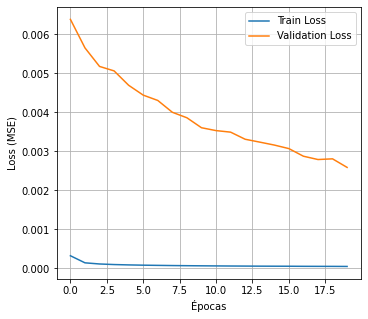

In [81]:
model = LSTM_model(X_train_seq, y_train_seq, window_size=10, train_size=0.8, epochs=20)
model

In [82]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 32)             │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,165 (78.77 KB)

 Trainable params: 6,721 (26.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,444 (52.52 KB)

### Avaliação 

In [83]:
def plot_error_histogram(y_pred, y_test):
    # Erro é o predito menos o real
    error = y_pred - y_test

    # Estatísticas do erro
    mean_error = np.mean(error)
    std_error = np.std(error)
    min_error = np.min(error)
    max_error = np.max(error)

    # Histograma
    plt.hist(error, bins=50, color='blue', alpha=0.7, edgecolor='black')

    # Linhas de referência
    plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=2, label=f"Média: {mean_error:.4f}")
    plt.axvline(mean_error + 2*std_error, color='green', linestyle='dashed', linewidth=2, label=f'+2σ: {(mean_error + 2*std_error):.4f}')
    plt.axvline(mean_error - 2*std_error, color='green', linestyle='dashed', linewidth=2, label=f'-2σ: {(mean_error - 2*std_error):.4f}')
    plt.axvline(min_error, color='purple', linestyle='dashed', linewidth=2, label=f'Mínimo: {min_error:.4f}')
    plt.axvline(max_error, color='orange', linestyle='dashed', linewidth=2, label=f'Máximo: {max_error:.4f}')

    # Extras
    plt.xlabel("Erro (y_pred - y_real)")
    plt.ylabel("Frequência")
    plt.legend()
    plt.grid(True)

    plt.show()

6824/6824 ━━━━━━━━━━━━━━━━━━━━ 3s 491us/step


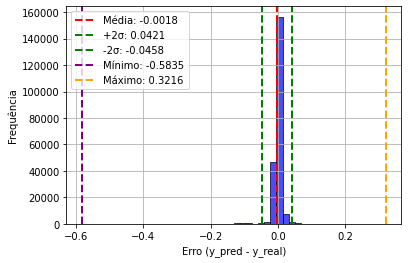

In [84]:
prediction = model.predict(X_test_seq)
y_pred_seq = prediction.reshape(1,-1)[0]

plot_error_histogram(y_pred_seq, y_test_seq)

(array([1.69160e+04, 9.83800e+03, 1.45340e+04, 2.03170e+04, 2.47150e+04,
        3.46540e+04, 5.96600e+04, 2.71729e+05, 2.36076e+05, 1.57940e+05,
        8.24450e+04, 4.99130e+04, 3.17360e+04, 2.14710e+04, 1.65480e+04,
        1.29050e+04, 9.42700e+03, 7.06400e+03, 5.20500e+03, 3.79100e+03,
        2.72600e+03, 1.80100e+03, 1.16600e+03, 9.03000e+02, 5.29000e+02,
        4.28000e+02, 1.71000e+02, 5.80000e+01, 3.80000e+01, 8.90000e+01]),
 array([-87.9       , -76.65333333, -65.40666667, -54.16      ,
        -42.91333333, -31.66666667, -20.42      ,  -9.17333333,
          2.07333333,  13.32      ,  24.56666667,  35.81333333,
         47.06      ,  58.30666667,  69.55333333,  80.8       ,
         92.04666667, 103.29333333, 114.54      , 125.78666667,
        137.03333333, 148.28      , 159.52666667, 170.77333333,
        182.02      , 193.26666667, 204.51333333, 215.76      ,
        227.00666667, 238.25333333, 249.5       ]),
 <BarContainer object of 30 artists>)

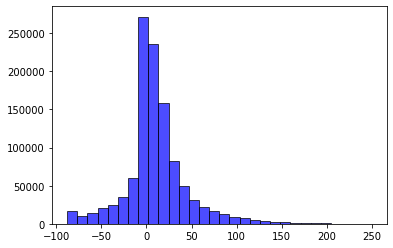

In [85]:
plt.hist(trips['Motor Torque [Nm]'], bins=30, color='blue', alpha=0.7, edgecolor='black')

## Modelo Torque e Throttle

### General Functions

In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

from IPython.display import display


WINDOW_SIZE = 10

In [2]:
directory = "./data/ieee/"
files = os.listdir(directory)
files.sort()

trips = []
for file in files:
    trip = pd.read_csv(directory + file, sep=";", encoding='unicode_escape')
    trip = trip.sort_values(by='Time [s]')
    trip['Trip'] = file.split(".")[0]
    if 'Velocity [km/h]]]' in trip.columns:
        trip = trip.rename(columns={'Velocity [km/h]]]': 'Velocity [km/h]'})
    trips.append(trip)

# Mapa (elet - comb):
# 'Ambient Temperature [°C]': 'Veh_ambient_temp_ECM',
# 'Cabin Temperature Sensor [°C]': 'HVAC_pass_compartment_air_temp_filt_HVAC',
# 'Heat Exchanger Temperature [°C]': 'HVAC_heater_core_coolant_temp_sensor_HVAC',
# 'Longitudinal Acceleration [m/s^2]': 'ActVehAccel',
# 'Throttle [%]': 'Eng_throttle_pos_ECM',
# 'Velocity [km/h]': 'VehSpdAvgDrvn'
colunas_selecionadas = [
    'Ambient Temperature [°C]',
    'Cabin Temperature Sensor [°C]',
    'Heat Exchanger Temperature [°C]',
    'Longitudinal Acceleration [m/s^2]',
    'Throttle [%]',
    'Velocity [km/h]',
    'Motor Torque [Nm]',
    'Time [s]',
    'Trip'
]


trips = pd.concat(trips)
trips = trips[colunas_selecionadas]
trips.shape

(1094793, 9)

In [32]:
def normalize(data, label):
    # Estou deixando 'Time [s]' no X pq os intervalos de tempo não são regulares
    columns = ['Trip', 'Throttle [%]', 'Motor Torque [Nm]']
    
    X = data.drop(columns=columns)
    y = data[label].values
    
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(X.values)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    
    X_scaled = pd.DataFrame(
        X_scaled,
        columns=X.columns,
        index=X.index
    )
    X_scaled['Trip'] = data['Trip']
    
    scaled_dataset = X_scaled
    scaled_dataset[label] = y_scaled

    return scaled_dataset, scaler_X, scaler_y

In [31]:
def time_series_train_test_split(dataset, label, train_size=0.8):
    X_trains, X_tests, y_trains, y_tests = [], [], [], []    
    
    for trip in dataset['Trip'].unique():
        data_slice = dataset[dataset['Trip'] == trip]
        size = int(len(data_slice) * train_size)
    
        X_trains.append(data_slice.drop(columns=[label]).iloc[:size, :])
        X_tests.append(data_slice.drop(columns=[label]).iloc[size:, :])
        
        y_trains.append(data_slice[label].iloc[:size])
        y_tests.append(data_slice[label].iloc[size:])
    
    return pd.concat(X_trains), pd.concat(X_tests), pd.concat(y_trains), pd.concat(y_tests)

In [5]:
def create_seq(X, y, window_size=10):
    X_seq, y_seq = [], []
    
    for i in range(window_size, len(X)):
        data_slice = X.iloc[i-window_size:i, :]

        # Se tiver mais de uma trip na mesma janela, eu não adiciono no conjunto de dados
        if len(data_slice['Trip'].unique()) == 1:
            X_seq.append(data_slice.drop(columns=['Trip']).values)
            y_seq.append(y[i])
        
    return np.array(X_seq), np.array(y_seq)

In [6]:
def LSTM_model(X_seq, y_seq, train_size=0.8, epochs=10):
    # Divisão de treino e validação com 80% para treino e 20% para validação
    train_size = int(len(X_seq) * train_size)
    X_train, X_test = X_seq[:train_size], X_seq[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]


    # Criando e treinando o modelo
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(32, activation='tanh'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=16)


    # Imprimindo a avaliação
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Épocas')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid()

    loss, mae = model.evaluate(X_test, y_test)
    print(f"MAE: {mae:.8f}, Loss: {loss:.8f}")

    return model

In [63]:
def plot_error_histogram(y_pred, y_test, bins=50, color='blue'):
    # Erro é o predito menos o real
    error = y_pred - y_test

    # Estatísticas do erro
    mean_error = np.mean(error)
    std_error = np.std(error)
    min_error = np.min(error)
    max_error = np.max(error)

    # Histograma
    plt.hist(error, bins=bins, color=color, alpha=0.7, edgecolor='black')

    # Linhas de referência
    plt.axvline(mean_error, color='red', linestyle='dashed', linewidth=2, label=f"Média: {mean_error:.4f}")
    plt.axvline(mean_error + 2*std_error, color='green', linestyle='dashed', linewidth=2, label=f'+2σ: {(mean_error + 2*std_error):.4f}')
    plt.axvline(mean_error - 2*std_error, color='green', linestyle='dashed', linewidth=2, label=f'-2σ: {(mean_error - 2*std_error):.4f}')
    plt.axvline(min_error, color='purple', linestyle='dashed', linewidth=2, label=f'Mínimo: {min_error:.4f}')
    plt.axvline(max_error, color='orange', linestyle='dashed', linewidth=2, label=f'Máximo: {max_error:.4f}')

    # Extras
    plt.xlabel("Erro (y_pred - y_real)")
    plt.ylabel("Frequência")
    plt.legend()
    plt.grid(True)

    plt.show()

### Torque

In [46]:
trips.head()

,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Throttle [%],Velocity [km/h],Motor Torque [Nm],Time [s],Trip
0,25.5,24.5,30.5,-0.03,0.0,0.0,0.0,0.0,TripA01
1,25.5,24.5,30.5,0.00,0.0,0.0,0.0,0.1,TripA01
2,25.5,24.5,30.5,-0.01,0.0,0.0,0.0,0.2,TripA01
3,25.5,24.5,30.5,-0.03,0.0,0.0,0.0,0.3,TripA01
4,25.5,24.5,30.5,-0.03,0.0,0.0,0.0,0.4,TripA01


In [33]:
torque_scaled_dataset, torque_X_scaler, torque_y_scaler = normalize(trips, 'Motor Torque [Nm]')
torque_scaled_dataset.head()

,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip,Motor Torque [Nm]
0,0.783784,0.485904,0.424646,0.667161,0.0,0.000000,TripA01,0.260522
1,0.783784,0.485904,0.424646,0.669385,0.0,0.000018,TripA01,0.260522
2,0.783784,0.485904,0.424646,0.668643,0.0,0.000036,TripA01,0.260522
3,0.783784,0.485904,0.424646,0.667161,0.0,0.000053,TripA01,0.260522
4,0.783784,0.485904,0.424646,0.667161,0.0,0.000071,TripA01,0.260522


In [45]:
torque_X_train, torque_X_test, torque_y_train, torque_y_test = time_series_train_test_split(torque_scaled_dataset, 'Motor Torque [Nm]')
print(f"\ntorque_X_train: {torque_X_train.shape}")
display(torque_X_train.head())

print(f"\ntorque_X_test: {torque_X_test.shape}")
display(torque_X_test.head())

print(f"\ntorque_y_train: {torque_y_train.shape}")
display(torque_y_train.head())

print(f"\ntorque_y_test: {torque_y_test.shape}")
display(torque_y_test.head())


torque_X_train: (875810, 7)


,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip
0,0.783784,0.485904,0.424646,0.667161,0.0,0.000000,TripA01
1,0.783784,0.485904,0.424646,0.669385,0.0,0.000018,TripA01
2,0.783784,0.485904,0.424646,0.668643,0.0,0.000036,TripA01
3,0.783784,0.485904,0.424646,0.667161,0.0,0.000053,TripA01
4,0.783784,0.485904,0.424646,0.667161,0.0,0.000071,TripA01



torque_X_test: (218983, 7)


,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip
8072,0.959459,0.413521,0.0,0.676798,0.001773,0.143883,TripA01
8073,0.959459,0.413521,0.0,0.633803,0.001314,0.143901,TripA01
8074,0.959459,0.413521,0.0,0.624166,0.001117,0.143919,TripA01
8075,0.959459,0.413521,0.0,0.643440,0.000854,0.143937,TripA01
8076,0.959459,0.413521,0.0,0.642698,0.000722,0.143955,TripA01



torque_y_train: (875810,)


0    0.260522
1    0.260522
2    0.260522
3    0.260522
4    0.260522
Name: Motor Torque [Nm], dtype: float64


torque_y_test: (218983,)


8072    0.236811
8073    0.246829
8074    0.260522
8075    0.260522
8076    0.260522
Name: Motor Torque [Nm], dtype: float64

In [48]:
torque_X_train_seq, torque_y_train_seq = create_seq(torque_X_train, torque_y_train.values, window_size=WINDOW_SIZE)
torque_X_test_seq, torque_y_test_seq = create_seq(torque_X_test, torque_y_test.values, window_size=WINDOW_SIZE)

print("TRAIN:")
print(f"torque_X_train_seq {torque_X_train_seq.shape}")
print(f"torque_y_train_seq {torque_y_train_seq.shape}")
print("\nTEST:")
print(f"torque_X_test_seq {torque_X_test_seq.shape}")
print(f"torque_y_test_seq {torque_y_test_seq.shape}")

TRAIN:
torque_X_train_seq (875179, 10, 6)
torque_y_train_seq (875179,)

TEST:
torque_X_test_seq (218352, 10, 6)
torque_y_test_seq (218352,)


Epoch 1/5
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step - loss: 9.7073e-04 - mae: 0.0194 - val_loss: 3.7538e-04 - val_mae: 0.0124
Epoch 2/5
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step - loss: 3.7133e-04 - mae: 0.0131 - val_loss: 3.6126e-04 - val_mae: 0.0127
Epoch 3/5
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - loss: 3.4265e-04 - mae: 0.0125 - val_loss: 3.7955e-04 - val_mae: 0.0139
Epoch 4/5
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - loss: 3.2788e-04 - mae: 0.0122 - val_loss: 3.7458e-04 - val_mae: 0.0125
Epoch 5/5
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 48s 1ms/step - loss: 3.1838e-04 - mae: 0.0119 - val_loss: 3.3943e-04 - val_mae: 0.0121
5470/5470 ━━━━━━━━━━━━━━━━━━━━ 3s 506us/step - loss: 3.0589e-04 - mae: 0.0117
MAE: 0.01209647, Loss: 0.00033943


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 32)             │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,245 (71.27 KB)

 Trainable params: 6,081 (23.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,164 (47.52 KB)

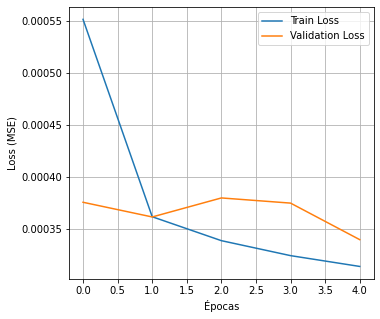

In [51]:
torque_model = LSTM_model(torque_X_train_seq, torque_y_train_seq, train_size=0.8, epochs=5)
torque_model.summary()

6824/6824 ━━━━━━━━━━━━━━━━━━━━ 4s 530us/step


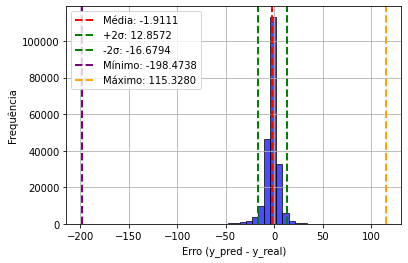

In [52]:
torque_y_pred_seq = torque_model.predict(torque_X_test_seq)
# y_pred_seq = prediction.reshape(1,-1)[0]

plot_error_histogram(
    torque_y_scaler.inverse_transform(torque_y_pred_seq), 
    torque_y_scaler.inverse_transform(torque_y_test_seq.reshape(len(torque_y_test_seq), 1)),
    bins=50
)

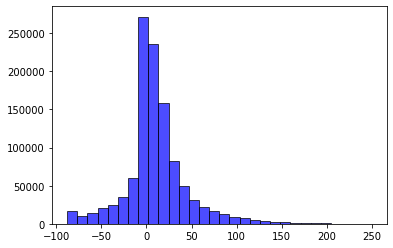

In [53]:
plt.hist(trips['Motor Torque [Nm]'], bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.show()

### Throttle

In [54]:
trips.head()

,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Throttle [%],Velocity [km/h],Motor Torque [Nm],Time [s],Trip
0,25.5,24.5,30.5,-0.03,0.0,0.0,0.0,0.0,TripA01
1,25.5,24.5,30.5,0.00,0.0,0.0,0.0,0.1,TripA01
2,25.5,24.5,30.5,-0.01,0.0,0.0,0.0,0.2,TripA01
3,25.5,24.5,30.5,-0.03,0.0,0.0,0.0,0.3,TripA01
4,25.5,24.5,30.5,-0.03,0.0,0.0,0.0,0.4,TripA01


In [55]:
throttle_scaled_dataset, throttle_X_scaler, throttle_y_scaler = normalize(trips, 'Throttle [%]')
throttle_scaled_dataset.head()

,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip,Throttle [%]
0,0.783784,0.485904,0.424646,0.667161,0.0,0.000000,TripA01,0.0
1,0.783784,0.485904,0.424646,0.669385,0.0,0.000018,TripA01,0.0
2,0.783784,0.485904,0.424646,0.668643,0.0,0.000036,TripA01,0.0
3,0.783784,0.485904,0.424646,0.667161,0.0,0.000053,TripA01,0.0
4,0.783784,0.485904,0.424646,0.667161,0.0,0.000071,TripA01,0.0


In [56]:
throttle_X_train, throttle_X_test, throttle_y_train, throttle_y_test = time_series_train_test_split(throttle_scaled_dataset, 'Throttle [%]')
print(f"\nthrottle_X_train: {throttle_X_train.shape}")
display(throttle_X_train.head())

print(f"\nthrottle_X_test: {throttle_X_test.shape}")
display(throttle_X_test.head())

print(f"\nthrottle_y_train: {throttle_y_train.shape}")
display(throttle_y_train.head())

print(f"\nthrottle_y_test: {throttle_y_test.shape}")
display(throttle_y_test.head())


throttle_X_train: (875810, 7)


,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip
0,0.783784,0.485904,0.424646,0.667161,0.0,0.000000,TripA01
1,0.783784,0.485904,0.424646,0.669385,0.0,0.000018,TripA01
2,0.783784,0.485904,0.424646,0.668643,0.0,0.000036,TripA01
3,0.783784,0.485904,0.424646,0.667161,0.0,0.000053,TripA01
4,0.783784,0.485904,0.424646,0.667161,0.0,0.000071,TripA01



throttle_X_test: (218983, 7)


,Ambient Temperature [°C],Cabin Temperature Sensor [°C],Heat Exchanger Temperature [°C],Longitudinal Acceleration [m/s^2],Velocity [km/h],Time [s],Trip
8072,0.959459,0.413521,0.0,0.676798,0.001773,0.143883,TripA01
8073,0.959459,0.413521,0.0,0.633803,0.001314,0.143901,TripA01
8074,0.959459,0.413521,0.0,0.624166,0.001117,0.143919,TripA01
8075,0.959459,0.413521,0.0,0.643440,0.000854,0.143937,TripA01
8076,0.959459,0.413521,0.0,0.642698,0.000722,0.143955,TripA01



throttle_y_train: (875810,)


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Throttle [%], dtype: float64


throttle_y_test: (218983,)


8072    0.0
8073    0.0
8074    0.0
8075    0.0
8076    0.0
Name: Throttle [%], dtype: float64

In [57]:
throttle_X_train_seq, throttle_y_train_seq = create_seq(throttle_X_train, throttle_y_train.values, window_size=WINDOW_SIZE)
throttle_X_test_seq, throttle_y_test_seq = create_seq(throttle_X_test, throttle_y_test.values, window_size=WINDOW_SIZE)

print("TRAIN:")
print(f"throttle_X_train_seq {throttle_X_train_seq.shape}")
print(f"throttle_y_train_seq {throttle_y_train_seq.shape}")
print("\nTEST:")
print(f"throttle_X_test_seq {throttle_X_test_seq.shape}")
print(f"throttle_y_test_seq {throttle_y_test_seq.shape}")

TRAIN:
throttle_X_train_seq (875179, 10, 6)
throttle_y_train_seq (875179,)

TEST:
throttle_X_test_seq (218352, 10, 6)
throttle_y_test_seq (218352,)


Epoch 1/5
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step - loss: 0.0045 - mae: 0.0451 - val_loss: 0.0134 - val_mae: 0.0575
Epoch 2/5
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step - loss: 0.0024 - mae: 0.0300 - val_loss: 0.0056 - val_mae: 0.0395
Epoch 3/5
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 49s 1ms/step - loss: 0.0020 - mae: 0.0273 - val_loss: 0.0039 - val_mae: 0.0394
Epoch 4/5
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 49s 1ms/step - loss: 0.0019 - mae: 0.0259 - val_loss: 0.0057 - val_mae: 0.0406
Epoch 5/5
43759/43759 ━━━━━━━━━━━━━━━━━━━━ 49s 1ms/step - loss: 0.0017 - mae: 0.0248 - val_loss: 0.0080 - val_mae: 0.0481
5470/5470 ━━━━━━━━━━━━━━━━━━━━ 3s 500us/step - loss: 0.0025 - mae: 0.0287
MAE: 0.04810197, Loss: 0.00801902


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 32)             │         4,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,245 (71.27 KB)

 Trainable params: 6,081 (23.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,164 (47.52 KB)

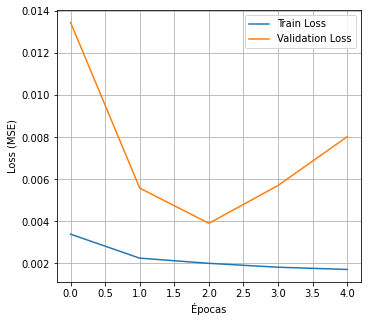

In [58]:
throttle_model = LSTM_model(throttle_X_train_seq, throttle_y_train_seq, train_size=0.8, epochs=5)
throttle_model.summary()

6824/6824 ━━━━━━━━━━━━━━━━━━━━ 3s 477us/step


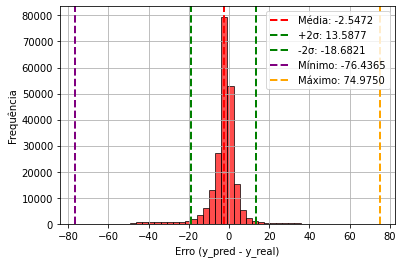

In [64]:
throttle_y_pred_seq = throttle_model.predict(throttle_X_test_seq)

plot_error_histogram(
    throttle_y_scaler.inverse_transform(throttle_y_pred_seq), 
    throttle_y_scaler.inverse_transform(throttle_y_test_seq.reshape(len(throttle_y_test_seq), 1)),
    bins=50,
    color='red'
)

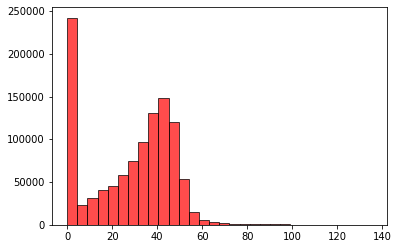

In [65]:
plt.hist(trips['Throttle [%]'], bins=30, color='red', alpha=0.7, edgecolor='black')
plt.show()

### Timeline

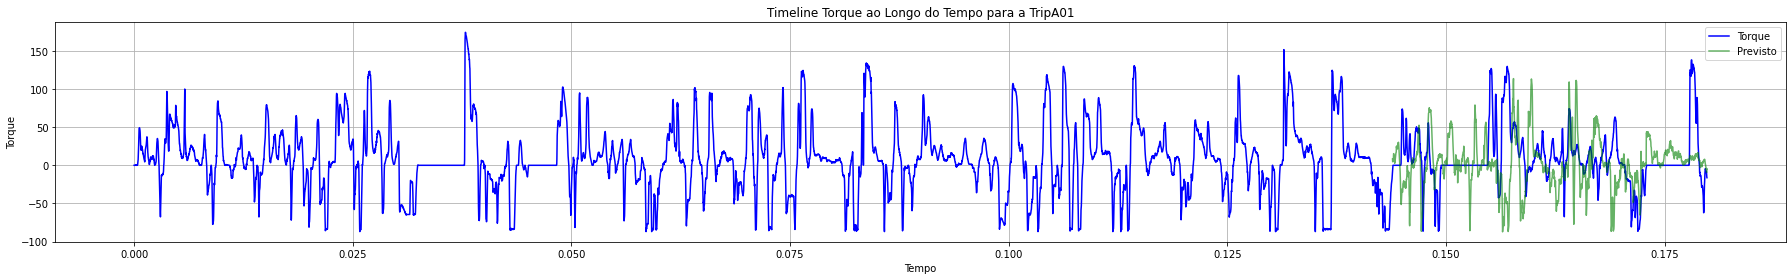

In [119]:
plt.figure(figsize=(25, 4))
plt.plot(
    torque_scaled_dataset[torque_scaled_dataset['Trip'] == 'TripA01']['Time [s]'], 
    torque_y_scaler.inverse_transform(torque_scaled_dataset[torque_scaled_dataset['Trip'] == 'TripA01']['Motor Torque [Nm]'].values.reshape(-1, 1)), 
    label='Torque',
    color='blue'
)

total_trip_size = len(torque_scaled_dataset[torque_scaled_dataset['Trip'] == 'TripA01']['Time [s]'])
size = int(total_trip_size*0.8)
plt.plot(
    torque_scaled_dataset[torque_scaled_dataset['Trip'] == 'TripA01']['Time [s]'].iloc[size:],
    torque_y_scaler.inverse_transform(torque_y_pred_seq)[size:total_trip_size],
    label='Previsto',
    color='green',
    alpha=0.6
)

plt.xlabel('Tempo')
plt.ylabel('Torque')
plt.title('Timeline Torque ao Longo do Tempo para a TripA01')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(25, 4))
plt.plot(
    throttle_scaled_dataset[throttle_scaled_dataset['Trip'] == 'TripA01']['Time [s]'], 
    throttle_y_scaler.inverse_transform(throttle_scaled_dataset[throttle_scaled_dataset['Trip'] == 'TripA01']['Throttle [%]'].values.reshape(-1, 1)), 
    label='Throttle',
    color='blue'
)

total_trip_size = len(throttle_scaled_dataset[throttle_scaled_dataset['Trip'] == 'TripA01']['Time [s]'])
size = int(total_trip_size*0.8)
plt.plot(
    throttle_scaled_dataset[throttle_scaled_dataset['Trip'] == 'TripA01']['Time [s]'].iloc[size:],
    throttle_y_scaler.inverse_transform(throttle_y_pred_seq)[size:total_trip_size],
    label='Previsto',
    color='red',
    alpha=0.6
)

plt.xlabel('Tempo')
plt.ylabel('Throttle')
plt.title('Timeline Throttle ao Longo do Tempo para a TripA01')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()